In [127]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [165]:
colloc_dist = np.array([0,0.15,0.35,0.65,0.85,1.0])
colloc_dist = np.array([0,0.35,0.75,1.0])
num_colloc = len(colloc_dist)

In [166]:
coeffs_to_colloc = np.array([colloc_dist**i for i in range(num_colloc)]).T
coeffs_to_colloc

array([[1.      , 0.      , 0.      , 0.      ],
       [1.      , 0.35    , 0.1225  , 0.042875],
       [1.      , 0.75    , 0.5625  , 0.421875],
       [1.      , 1.      , 1.      , 1.      ]])

In [167]:
coeffs_to_colloc_deriv = np.vstack((colloc_dist*0,  np.array([i*colloc_dist**(i-1) for i in range(1,num_colloc)]))).T
coeffs_to_colloc_deriv

array([[0.    , 1.    , 0.    , 0.    ],
       [0.    , 1.    , 0.7   , 0.3675],
       [0.    , 1.    , 1.5   , 1.6875],
       [0.    , 1.    , 2.    , 3.    ]])

In [168]:
colloc_to_colloc_deriv = coeffs_to_colloc_deriv@np.linalg.inv(coeffs_to_colloc)
colloc_to_colloc_deriv

array([[-5.19047619,  8.24175824, -4.66666667,  1.61538462],
       [-0.99047619, -1.18131868,  3.03333333, -0.86153846],
       [ 0.38095238, -2.06043956, -0.16666667,  1.84615385],
       [-0.61904762,  2.74725275, -8.66666667,  6.53846154]])

In [169]:
def dynamics_constraints(z):
    x = z[0:num_colloc]
    y = z[num_colloc:(2*num_colloc)]
    h = z[(2*num_colloc):(3*num_colloc)]
    v = z[(3*num_colloc):(4*num_colloc)]
    k = z[(4*num_colloc):(5*num_colloc)]
    T = z[-1]
    xdot_err = (1/T)*colloc_to_colloc_deriv@x - v*np.sin(h) # x-dot = v sin h
    ydot_err = (1/T)*colloc_to_colloc_deriv@y - v*np.cos(h) # y-dot = v cos h
    hdot_err = (1/T)*colloc_to_colloc_deriv@h - v*k # h-dot = v k
    return np.hstack((xdot_err,ydot_err,hdot_err))

In [170]:
s0 = (0,0,-np.pi/4)
sf = (5,5,-np.pi/4)
def boundary_constraints(z):
    init_err = np.array([s0[i] - z[i*num_colloc] for i in range(len(s0))])
    term_err = np.array([sf[i] - z[num_colloc + i*num_colloc - 1] for i in range(len(sf))])
    return np.hstack((init_err,term_err))

In [171]:
z = np.hstack((np.linspace(s0[0],sf[0],num_colloc),
               np.linspace(s0[1],sf[1],num_colloc),
               np.linspace(s0[2],sf[2],num_colloc),
               np.ones_like(colloc_dist)*1.8,
               np.zeros_like(colloc_dist),
               5.0))
z

array([ 0.        ,  1.66666667,  3.33333333,  5.        ,  0.        ,
        1.66666667,  3.33333333,  5.        , -0.78539816, -0.78539816,
       -0.78539816, -0.78539816,  1.8       ,  1.8       ,  1.8       ,
        1.8       ,  0.        ,  0.        ,  0.        ,  0.        ,
        5.        ])

In [172]:
dynamics_constraints(z)

array([ 2.52431846e+00,  2.03970307e+00,  2.32102175e+00,  2.94922688e+00,
       -2.12659546e-02, -5.05881339e-01, -2.24562658e-01,  4.03642470e-01,
        0.00000000e+00, -1.11022302e-16, -2.77555756e-17,  2.22044605e-16])

In [173]:
boundary_constraints(z)

array([0., 0., 0., 0., 0., 0.])

In [174]:
bounds = [(-10,10)]*2*num_colloc + [(-np.pi,np.pi)]*num_colloc + [(0,3)]*num_colloc + [(-2,2)]*num_colloc + [(0.001,100.0)]
bounds

[(-10, 10),
 (-10, 10),
 (-10, 10),
 (-10, 10),
 (-10, 10),
 (-10, 10),
 (-10, 10),
 (-10, 10),
 (-3.141592653589793, 3.141592653589793),
 (-3.141592653589793, 3.141592653589793),
 (-3.141592653589793, 3.141592653589793),
 (-3.141592653589793, 3.141592653589793),
 (0, 3),
 (0, 3),
 (0, 3),
 (0, 3),
 (-2, 2),
 (-2, 2),
 (-2, 2),
 (-2, 2),
 (0.001, 100.0)]

In [186]:
def all_eq_constraints(z):
    return np.hstack((dynamics_constraints(z),boundary_constraints(z)))

all_eq_constraints(z)

array([ 2.52431846e+00,  2.03970307e+00,  2.32102175e+00,  2.94922688e+00,
       -2.12659546e-02, -5.05881339e-01, -2.24562658e-01,  4.03642470e-01,
        0.00000000e+00, -1.11022302e-16, -2.77555756e-17,  2.22044605e-16,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [187]:
constraints = [{'type':'eq','fun':all_eq_constraints}]

In [176]:
def cost(z):
    return(z[-1])

In [188]:
res = minimize(cost,z,method='SLSQP',bounds=bounds,constraints=constraints,options={'maxiter':300})
res

 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 6.876392322591542
       x: [ 6.740e-16  1.402e+00 ... -2.000e+00  6.876e+00]
     nit: 18
     jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
    nfev: 405
    njev: 17

In [178]:
res.x

array([ 6.73952606e-16,  1.40235669e+00,  4.24069829e+00,  5.00000000e+00,
        3.22652468e-16,  1.40235667e+00,  4.24069819e+00,  5.00000000e+00,
       -7.85398163e-01,  3.13631456e-01,  1.20395485e-01, -7.85398163e-01,
        5.00054697e-08,  0.00000000e+00,  1.06899466e-08,  0.00000000e+00,
       -6.79229794e-01,  4.92276054e-01,  2.00000000e+00, -2.00000000e+00,
        6.87639232e+00])

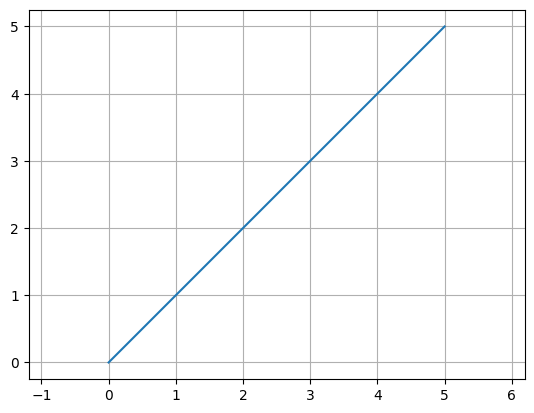

In [179]:
plt.plot(res.x[0:num_colloc],res.x[num_colloc:(2*num_colloc)])
plt.axis('equal')
plt.grid('on')
plt.show()

In [184]:
dynamics_constraints(res.x)

array([-0.02255794,  1.00330649,  0.81939987, -0.0302168 , -0.02255796,
        1.00330644,  0.81939987, -0.03021668,  0.70253403,  0.2107602 ,
       -0.35126702, -0.70253401])

In [185]:
boundary_constraints(res.x)

array([-6.73952606e-16, -3.22652468e-16, -4.44089210e-16,  8.88178420e-16,
        0.00000000e+00, -1.11022302e-16])

In [180]:
eval_dist = np.linspace(0,1,100)

In [181]:
coeffs_to_eval = np.array([eval_dist**i for i in range(len(colloc_dist))]).T
coeffs_to_eval

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.01010101e-02, 1.02030405e-04, 1.03061015e-06],
       [1.00000000e+00, 2.02020202e-02, 4.08121620e-04, 8.24488122e-06],
       [1.00000000e+00, 3.03030303e-02, 9.18273646e-04, 2.78264741e-05],
       [1.00000000e+00, 4.04040404e-02, 1.63248648e-03, 6.59590497e-05],
       [1.00000000e+00, 5.05050505e-02, 2.55076013e-03, 1.28826269e-04],
       [1.00000000e+00, 6.06060606e-02, 3.67309458e-03, 2.22611793e-04],
       [1.00000000e+00, 7.07070707e-02, 4.99948985e-03, 3.53499282e-04],
       [1.00000000e+00, 8.08080808e-02, 6.52994592e-03, 5.27672398e-04],
       [1.00000000e+00, 9.09090909e-02, 8.26446281e-03, 7.51314801e-04],
       [1.00000000e+00, 1.01010101e-01, 1.02030405e-02, 1.03061015e-03],
       [1.00000000e+00, 1.11111111e-01, 1.23456790e-02, 1.37174211e-03],
       [1.00000000e+00, 1.21212121e-01, 1.46923783e-02, 1.78089434e-03],
       [1.00000000e+00, 1.31313131e-01, 1.72431385e

In [182]:
colloc_to_eval = coeffs_to_eval@np.linalg.inv(coeffs_to_colloc)

In [183]:
colloc_test = np.array([1,2,2,3,3,2])
eval_test = colloc_to_eval@colloc_test
plt.plot(colloc_dist,colloc_test,'*r-')
plt.plot(eval_dist,eval_test,'b-')
plt.show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 6 is different from 4)

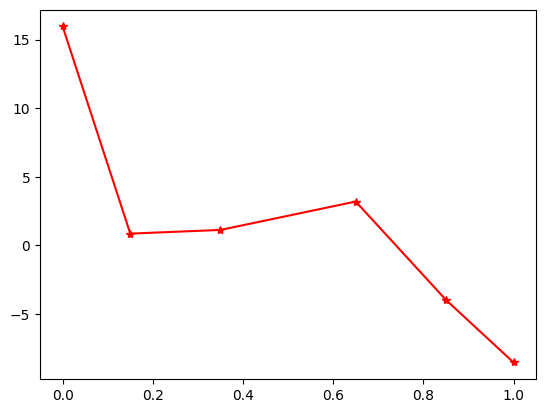

In [ ]:
colloc_deriv_test = colloc_to_colloc_deriv@colloc_test
plt.plot(colloc_dist,colloc_deriv_test,'*r-')
plt.show()